In [1]:
%matplotlib notebook

import corex as cx
import vis_corex as vcx
from gensim import models
import numpy as np
from time import time
import re
from itertools import groupby
import matplotlib.pyplot as plt

/home/mcapizzi/anaconda3/envs/corex/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Load embeddings using `gensim`

In [2]:
embeddings_gensim = models.KeyedVectors.load_word2vec_format(fname="data/vectors_Goldberg_sample.txt", binary=False)
# capture indexes
word_idxs = list(map(lambda x: x[0], embeddings_gensim.vocab.items()))
word_idxs[:5]

['the', '.', ',', 'is', 'and']

# Load embeddings into `numpy` matrix

In [3]:
emb_matrix = embeddings_gensim.syn0
emb_matrix.shape

(4999, 300)

# Build single layer `CoRex` representation

## hyperparameters

In [4]:
num_hidden = 2      # number of Y_s; number of clusters?  m?
cluster_dim = 20      # dimension of each hidden; k?
max_samples = emb_matrix.shape[0]
max_iter=12          # previous runs show this is sufficient
random_seed = 1978

In [5]:
corex_layer_1 = cx.Corex(
    n_hidden=num_hidden,            
    dim_hidden=cluster_dim,            
    marginal_description='gaussian',   # for continuous data
    max_iter=max_iter,
    max_samples=max_samples,
    seed=random_seed,
    verbose=True,
    ram=2
)

corex, rep size: 2 20
Marginal description:  gaussian


## fit

In [6]:
t0 = time()
ys_layer_1 = corex_layer_1.fit_transform(emb_matrix)
print("time to compute: {} seconds".format(time() - t0))

[ 0.067  0.051]
[ 3.733  2.687]
[ 11.102  12.465]
[ 16.333  18.524]
[ 19.289  18.771]
[ 20.068  18.406]
[ 20.082  18.847]
[ 21.162  18.362]
[ 21.012  18.783]
[ 21.534  18.609]
[ 21.671  18.692]
[ 21.881  18.655]
Overall tc: 40.5361557669
Best tc: 40.5361557669
time to compute: 261.4387409687042 seconds


## labels

`.labels` is the size of your data.  And `.labels[i]` gives you the values for each $Y_j$ for the $i^{th}$ datapoint

In [7]:
corex_layer_1.labels[0]

array([ 5, 17])

So....in theory, two words with a high `cosine similarity` in embedding space, should also have similar `label vectors`.

In [8]:
embeddings_gensim.most_similar(["his"])

[('their', 0.8471860885620117),
 ('its', 0.7965162396430969),
 ('my', 0.7934165000915527),
 ('your', 0.7914167642593384),
 ('our', 0.7593696713447571),
 ('whose', 0.738511323928833),
 ('her', 0.6965184211730957),
 ('the', 0.4893943667411804),
 ('``', 0.4586181342601776),
 ("'ll", 0.4517585039138794)]

In [9]:
index_of_his = word_idxs.index('his')
index_of_their = word_idxs.index('their')

corex_layer_1.labels[index_of_his], corex_layer_1.labels[index_of_their]

(array([5, 6]), array([5, 6]))

And presumably two `dissimilar` words in embedding space should have dissimilar `label vectors`.

In [10]:
embeddings_gensim.most_similar(["his"], topn=len(word_idxs))[-3:]

[('eleven', 0.07403583079576492),
 ('announced', 0.06627192348241806),
 ('premiere', 0.05658423900604248)]

In [11]:
index_of_premiere = word_idxs.index('premiere')

corex_layer_1.labels[index_of_his], corex_layer_1.labels[index_of_premiere]

(array([5, 6]), array([17, 15]))

## plot

We can plot all the words on the 2 dimensions...

In [12]:
coordinates = {}
for idx, label in enumerate(corex_layer_1.labels):
    coord = tuple(label)
    if coord in coordinates:
        coordinates[coord].append(word_idxs[idx])
    else:
        coordinates[coord] = [word_idxs[idx]]

<IPython.core.display.Javascript object>


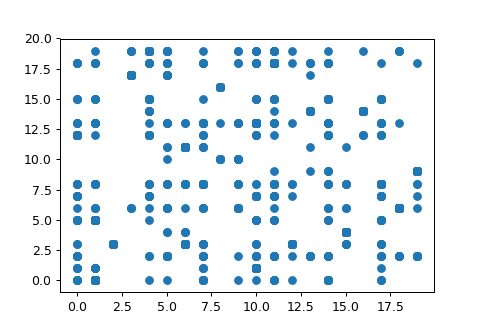

In [19]:
xs, ys = zip(*corex_layer_1.labels)
plt.scatter(
    xs, 
    ys
)

In [14]:
for coordinate_pair, words_ in sorted(coordinates.items(), key=lambda x: (x[0], x[1])):
    print("The coordinate pair {} contains the following {} words:\n{}".format(
        coordinate_pair, len(words_), ",".join(words_)
        )
    )
    print("\n")

The coordinate pair (0, 0) contains the following 8 words:
history,language,policy,environment,religion,philosophy,strategy,curriculum


The coordinate pair (0, 1) contains the following 4 words:
technology,staff,legislation,infrastructure


The coordinate pair (0, 2) contains the following 18 words:
football,sports,justice,baseball,sport,hockey,basketball,cricket,soccer,clan,nfl,vice,tennis,athletics,obama,golf,cult,islam


The coordinate pair (0, 3) contains the following 2 words:
advertising,marketing


The coordinate pair (0, 5) contains the following 43 words:
life,development,rights,management,health,money,security,relations,defense,leadership,peace,opposition,establishment,freedom,independence,traffic,promotion,sales,safety,partnership,intelligence,tax,collaboration,membership,communication,defence,funding,ownership,transportation,income,investment,budget,jurisdiction,relief,cooperation,conservation,enforcement,wealth,therapy,employment,regulation,legacy,exploration


The coordi


The coordinate pair (10, 2) contains the following 11 words:
brothers,parents,sons,champions,kings,sisters,daughters,saints,giants,tigers,founders


The coordinate pair (10, 3) contains the following 3 words:
hosts,approaches,cuts


The coordinate pair (10, 5) contains the following 10 words:
goals,efforts,contributions,losses,improvements,injuries,difficulties,temperatures,ratings,achievements


The coordinate pair (10, 7) contains the following 71 words:
men,forces,families,officers,ships,troops,soldiers,leaders,workers,residents,towns,churches,villages,citizens,americans,guns,inhabitants,jews,personnel,provinces,tribes,territories,prisoners,indians,governments,victims,supporters,settlers,peoples,allies,populations,fighters,immigrants,tanks,volunteers,guards,rangers,settlements,camps,campaigns,crimes,farmers,warriors,colonies,germans,ministers,knights,opponents,pilots,enemies,armies,democrats,descendants,municipalities,politicians,chiefs,christians,pirates,muslims,reserves,farms,sla

## tcs

`.tcs` provides the `total correlation` captured by each $Y_j$, and are sorted from greatest to least.

In [15]:
corex_layer_1.tcs

array([ 21.881,  18.655])

So in this case, $Y_0$ captures the most `total correlation`.

## clusters

This will identify which cluster each `dimension` of the word embedding should belong to.  See this example:

```
X = np.array([[0,0,0,0,0], # A matrix with rows as samples and columns as variables.
              [0,0,0,1,1],
              [1,1,1,0,0],
              [1,1,1,1,1]], dtype=int)

layer1 = ce.Corex(n_hidden=2, dim_hidden=2, marginal_description='discrete', smooth_marginals=False)  

layer1.fit(X)  # Fit on data. 

layer1.clusters  # Each variable/column is associated with one Y_j
# array([0, 0, 0, 1, 1])
```

You can see that the first three `dimension`s belong together (in cluster `0`) and the last two together.

In [16]:
clusters = corex_layer_1.clusters
clusters

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1])

This generates a clustering of each `dimension` of the word embeddings.  Not sure what meaning this may carry...if any.

In [17]:
clusters = corex_layer_1.clusters
clusters_grouped = groupby(enumerate(clusters), lambda x: x[1])
clusters_dict = {}
for idx, group in clusters_grouped:
    just_dims = list(map(lambda x: x[0], group))
    if idx in clusters_dict:
        clusters_dict[idx].extend(just_dims)
    else:
        clusters_dict[idx] = just_dims
for c, dims in clusters_dict.items():
    print("cluster {} has {} dims".format(c, len(dims)))

cluster 0 has 187 dims
cluster 1 has 113 dims


## visualize

Runs code to generate a bunch of visualizations, which will end up in the directory called `embedding_viz`.

Note: Errors when `k>3`.  But some things are still generated...

In [18]:
vcx.vis_rep(
    corex=corex_layer_1, 
    data=emb_matrix,
    row_label=word_idxs,
    column_label=None,
    prefix="embedding_viz_20_x_2_dim",
    topk=num_hidden
)

Groups in sorted_groups.txt
Pairwise plots among high TC variables in "relationships"
error, not able to visualize with k > 3


UnboundLocalError: local variable 'out' referenced before assignment

## groups

In [23]:
path_to_groups = "embedding_viz_20_x_2_dim/text_files/groups_no_overlaps.txt"

In [24]:
group_regex = r'Group num: ([0-9]+), TC.*'
groups = {}
groups_list = []
with open(path_to_groups, "r") as f:
    for line in f:
        if line.startswith("Group num"):
            group_number = re.match(group_regex, line)[1]
            if groups_list:
                groups[int(group_number) - 1] = groups_list
            groups_list = []
        else:
            dim, val = line.rstrip().split(",")
            groups_list.append((dim, val))
groups[int(group_number)] = groups_list

In [25]:
for g, dims in groups.items():
    print("There are {} dims in group {} with a total TCS of {}:\n{}".format(
        len(dims), g, corex_layer_1.tcs[g], ",".join(list(map(lambda x: x[0], dims)))
        )
    )
    print("----")

There are 187 dims in group 0 with a total TCS of 21.880908942948157:
78,173,242,25,41,11,0,272,14,191,227,197,288,16,238,186,125,262,239,240,216,109,15,187,72,277,156,207,211,237,136,248,1,119,22,154,256,92,82,218,111,29,32,108,195,2,45,147,54,205,42,43,220,28,270,79,234,295,185,74,144,30,289,57,190,267,189,60,126,104,131,194,64,52,150,221,212,157,217,37,122,245,209,244,153,63,141,226,263,56,80,20,224,13,89,247,113,229,167,170,46,181,107,179,18,219,243,259,198,71,258,261,94,281,159,285,77,172,121,40,117,274,146,233,112,38,10,115,273,231,210,67,294,55,206,106,166,133,135,19,160,81,49,134,152,287,76,208,39,268,278,53,44,91,223,123,246,105,61,232,162,260,199,255,182,139,291,138,290,228,96,83,120,50,65,214,158,99,235,142,9,151,51,102,100,254,70
----
There are 113 dims in group 1 with a total TCS of 18.65524682395081:
35,73,296,184,143,84,17,280,48,213,66,265,225,275,161,34,188,204,266,8,155,85,163,140,241,47,171,110,169,298,90,118,174,3,251,202,128,36,68,88,59,137,132,62,253,7,271,279,75,

The fact that both groups have a relatively equal amount of `TCS` tells me this data may not do well being represented with only `2 hidden dims`.

## anomalies

In [26]:
path_to_anomalies = "embedding_viz_20_x_2_dim/text_files/anomalies.txt"

In [32]:
anomalies = []
with open(path_to_anomalies, "r") as f:
    for line in f:
        idx, val = line.rstrip().split(",")
        idx = int(idx)
        val = float(val.strip())
        anomalies.append((word_idxs[idx], val))
anomalies.sort(key=lambda x: x[1])
anomalies

[('was', 3.6),
 (')', 3.6),
 ('drew', 3.7),
 ('not', 3.7),
 ('this', 3.8),
 ('as', 3.8),
 ('had', 3.9),
 ("''", 3.9),
 ('resolution', 3.9),
 ('are', 4.0),
 ('a', 4.1),
 ('(', 4.1),
 ('has', 4.1),
 ('districts', 4.1),
 ('driver', 4.2),
 ('that', 4.3),
 ('i', 4.3),
 ('been', 4.3),
 ('one', 4.4),
 ('horse', 4.4),
 ('his', 4.5),
 ("'s", 4.5),
 ('painted', 4.5),
 ('benefit', 4.5),
 ('were', 4.6),
 ('made', 4.6),
 ('opposition', 4.6),
 ('hard', 4.7),
 ('it', 4.7),
 ('used', 4.7),
 ('an', 4.7),
 ('arms', 4.7),
 ('pair', 4.7),
 ('have', 4.8),
 ('asks', 4.8),
 ('causing', 4.8),
 ('starring', 4.9),
 ('martin', 4.9),
 ('lose', 5.0),
 ('unable', 5.1),
 ('aspects', 5.2),
 ('structures', 5.3),
 ('spend', 5.3),
 ('background', 5.3),
 ('decides', 5.3),
 ('seats', 5.3),
 ('price', 5.4),
 ('trees', 5.4),
 ('lands', 5.5),
 ('27', 5.6),
 ('definition', 5.7),
 ('partner', 5.7),
 ('true', 5.7),
 ('asia', 5.8),
 ('spain', 5.8),
 ('target', 5.8),
 ('seemed', 5.9),
 ('regular', 5.9),
 ('1992', 5.9),
 ('traditi

Not sure how these are calculated or what they mean....